In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

ModuleNotFoundError: No module named 'torch'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [5]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cpu


/home/user1/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# 5x: raw/flip/rotate/jitter/blur
# ResNet & VGG
CFG={'SEED' : 42,  # 42~46
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율
     'MODEL' : 3,  # 1: ResNet / 2: VGG / 3: Inception_v3
     'CONTROL' : "NORMAL",  # "NORMAL" or "NON_SJS"
     'gland' : "PTG_",  # "PTG_" or "SMG_"
     'EPOCHS' : 30,
     'BATCH_SIZE' : 64,
     'LR' : 1e-4}

In [5]:
seed_everything(CFG["SEED"])

In [6]:
control = CFG["CONTROL"]
seed = CFG["SEED"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["gland"] == "PTG_":
    gland = "PG"
else:
    gland = "SG"

if CFG["MODEL"] == 1:
    model_name = "Res"
elif CFG["MODEL"] == 2:
    model_name = "VGG"
else:
    model_name = "Inception"

model_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_{model_name})_seed{seed}.pt"

In [7]:
model_save_path  # model_save_path 제대로 호출했는지 확인하기

"/home/user1/바탕화면/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(SG_Inception)_seed46.pt"

In [8]:
# 파일 경로 가져오기
# PG: Parotid Gland (귀밑샘)
# SG: Submandibular Gland (턱밑샘)
def GET_PATH(path, control_group, gland):
    # Control group: "NORMAL" or "NON_SJS" (문자열 입력)
    # Gland: "PTG_" or "SMG_" (문자열 입력)
    control_list, sjs_list = [], []
    control_label, sjs_label = [], []
    for diagnosis in os.listdir(path):
        if diagnosis == control_group:    # CONTROL: NORMAL / NON_SJS
            control_path = path + diagnosis + f"/"
            for control_img in os.listdir(control_path):
                control_img_path = control_path + control_img
                if gland in control_img:
                    control_list.append(control_img_path)
                    control_label.append(np.array([0,1]))
        elif diagnosis == 'SJS':
            sjs_path = path + diagnosis + f"/"
            for sjs_img in os.listdir(sjs_path):
                sjs_img_path = sjs_path + sjs_img
                if gland in sjs_img:
                    sjs_list.append(sjs_img_path)
                    sjs_label.append(np.array([1,0]))
    
    return control_list, sjs_list, control_label, sjs_label

In [9]:
# Total_Data -> PG / SG -> NORMAL / SJS
root_path = f"C:/Users/PC00/Desktop/Project2/AICOSS/Total_Data/"
control_path, sjs_path, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"], CFG['gland'])

In [10]:
total_path = control_path + sjs_path
total_label = control_label + sjs_label

print(f"TOTAL: {len(total_path)}")
print(f"CONTROL: {len(control_path)}")
print(f"SJS: {len(sjs_path)}")

TOTAL: 1760
CONTROL: 628
SJS: 1132


In [11]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

rotate_aug=transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

flip_aug=transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

jitter_aug=transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

blur_aug=transforms.Compose([
    transforms.GaussianBlur((3,3), sigma=(0.1,0.2)),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

augmentation = [flip_aug, rotate_aug, jitter_aug, blur_aug]

class CustomDataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img__(self, path):
        img = PIL.Image.open(path)
        return img
    
    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img__(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [12]:
test_control_length = int(CFG['TEST_PORTION']*len(control_path))
test_control_indexes = random.sample(range(0,len(control_path)), test_control_length)
train_control_indexes = list(set(list(range(0,len(control_path))))-set(test_control_indexes))

test_sjs_length = int(CFG['TEST_PORTION']*len(sjs_path))
test_sjs_indexes = random.sample(range(0,len(sjs_path)), test_sjs_length)
train_sjs_indexes = list(set(list(range(0,len(sjs_path))))-set(test_sjs_indexes))

test_path = list(map(lambda x: control_path[x], test_control_indexes)) + list(map(lambda x: sjs_path[x], test_sjs_indexes))
test_label = list(map(lambda x: control_label[x], test_control_indexes)) + list(map(lambda x: sjs_label[x], test_sjs_indexes))
train_path = list(map(lambda x: control_path[x], train_control_indexes)) + list(map(lambda x: sjs_path[x], train_sjs_indexes))
train_label = list(map(lambda x: control_label[x], train_control_indexes)) + list(map(lambda x: sjs_label[x], train_sjs_indexes))

print(f"PLAIN TRAIN: {len(train_path)}")
print(f"PLAIN TEST: {len(test_path)}")
print(f"TOTAL: {len(train_path)+len(test_path)} == {len(total_path)}")
print()

train_dataset = CustomDataset(train_path, train_label, transform=preprocessing)
if CFG['AUGMENTATION'] == 1:
    train_dataset += CustomDataset(train_path, train_label, transform=augmentation[0])
else:
    for i in range(len(augmentation)):
        train_dataset += CustomDataset(train_path, train_label, transform=augmentation[i])

test_dataset = CustomDataset(test_path, test_label, transform=preprocessing)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

print(f"TRAIN: {len(train_dataset)}, TEST: {len(test_dataset)}")
print(f"Train CONTROL indexes: {train_control_indexes[:5]}")
print(f"Test CONTROL indexes: {test_control_indexes[:5]}")
print(f"Train SJS indexes: {train_sjs_indexes[:5]}")
print(f"Test SJS indexes: {test_sjs_indexes[:5]}")

PLAIN TRAIN: 880
PLAIN TEST: 880
TOTAL: 1760 == 1760

TRAIN: 4400, TEST: 880
Train CONTROL indexes: [2, 4, 5, 10, 12]
Test CONTROL indexes: [78, 409, 40, 602, 600]
Train SJS indexes: [0, 1, 2, 5, 6]
Test SJS indexes: [604, 714, 797, 732, 582]


In [13]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img[0].shape}")
print(f"Label shape: {label[0].shape}")

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([2])


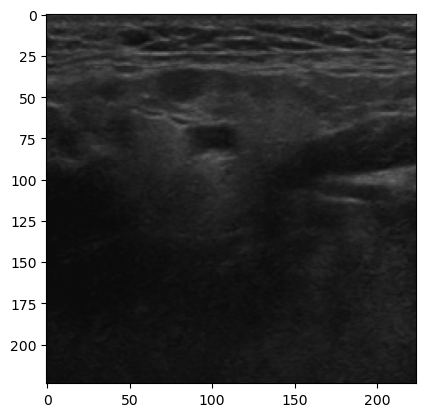

In [14]:
sample_img = transforms.functional.to_pil_image(img[0])
plt.imshow(sample_img)

In [15]:
import timm

class CustomModel(nn.Module):
    if CFG['MODEL'] == 1:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("resnet50", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x

    elif CFG['MODEL'] == 2:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("vgg16_bn", pretrained=True)
            self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x
    
    elif CFG['MODEL'] == 3:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("inception_v3", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)

            return x

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [16]:
model = CustomModel().to(device)
model

CustomModel(
  (model): InceptionV3(
    (Conv2d_1a_3x3): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2a_3x3): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2b_3x3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [17]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# TRAIN DATASET

In [18]:
def train_loop(dataloader, model, optimizer, loss_fn, scheduler, model_save_path):
    # model.load_state_dict(torch.load(model_save_path))
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    best_loss = 100
    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 50 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        curr_loss = loss_item/size
        curr_acc = correct/datasize
        loss_hist.append(curr_loss)
        acc_hist.append(curr_acc*100)

        if curr_loss < best_loss:
            best_loss = curr_loss
            best_loss_model = deepcopy(model.state_dict())

        print(f"Loss : {(curr_loss):>.5f} ACC : {(curr_acc*100):>.2f}%")

        epoch_end = time.time()
        scheduler.step()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(best_loss_model, model_save_path)

    return loss_hist, acc_hist

In [19]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, scheduler, model_save_path)

Start epoch : 1
Batch loss : 0.69039 0/69
Batch loss : 0.43908 50/69
Loss : 0.53650 ACC : 76.59%
End epoch : 1
Epoch time : 0.0 min 34.85112643241882 sec

Start epoch : 2
Batch loss : 0.40584 0/69
Batch loss : 0.38353 50/69
Loss : 0.37885 ACC : 93.82%
End epoch : 2
Epoch time : 0.0 min 30.98775577545166 sec

Start epoch : 3
Batch loss : 0.35497 0/69
Batch loss : 0.36471 50/69
Loss : 0.35107 ACC : 96.36%
End epoch : 3
Epoch time : 0.0 min 31.733426809310913 sec

Start epoch : 4
Batch loss : 0.35621 0/69
Batch loss : 0.33799 50/69
Loss : 0.34396 ACC : 97.02%
End epoch : 4
Epoch time : 0.0 min 31.69182586669922 sec

Start epoch : 5
Batch loss : 0.34562 0/69
Batch loss : 0.33113 50/69
Loss : 0.33517 ACC : 97.91%
End epoch : 5
Epoch time : 0.0 min 31.320414543151855 sec

Start epoch : 6
Batch loss : 0.34465 0/69
Batch loss : 0.34142 50/69
Loss : 0.33114 ACC : 98.20%
End epoch : 6
Epoch time : 0.0 min 31.19785475730896 sec

Start epoch : 7
Batch loss : 0.34243 0/69
Batch loss : 0.34775 50/69

Text(0.5, 1.0, 'Train Loss')

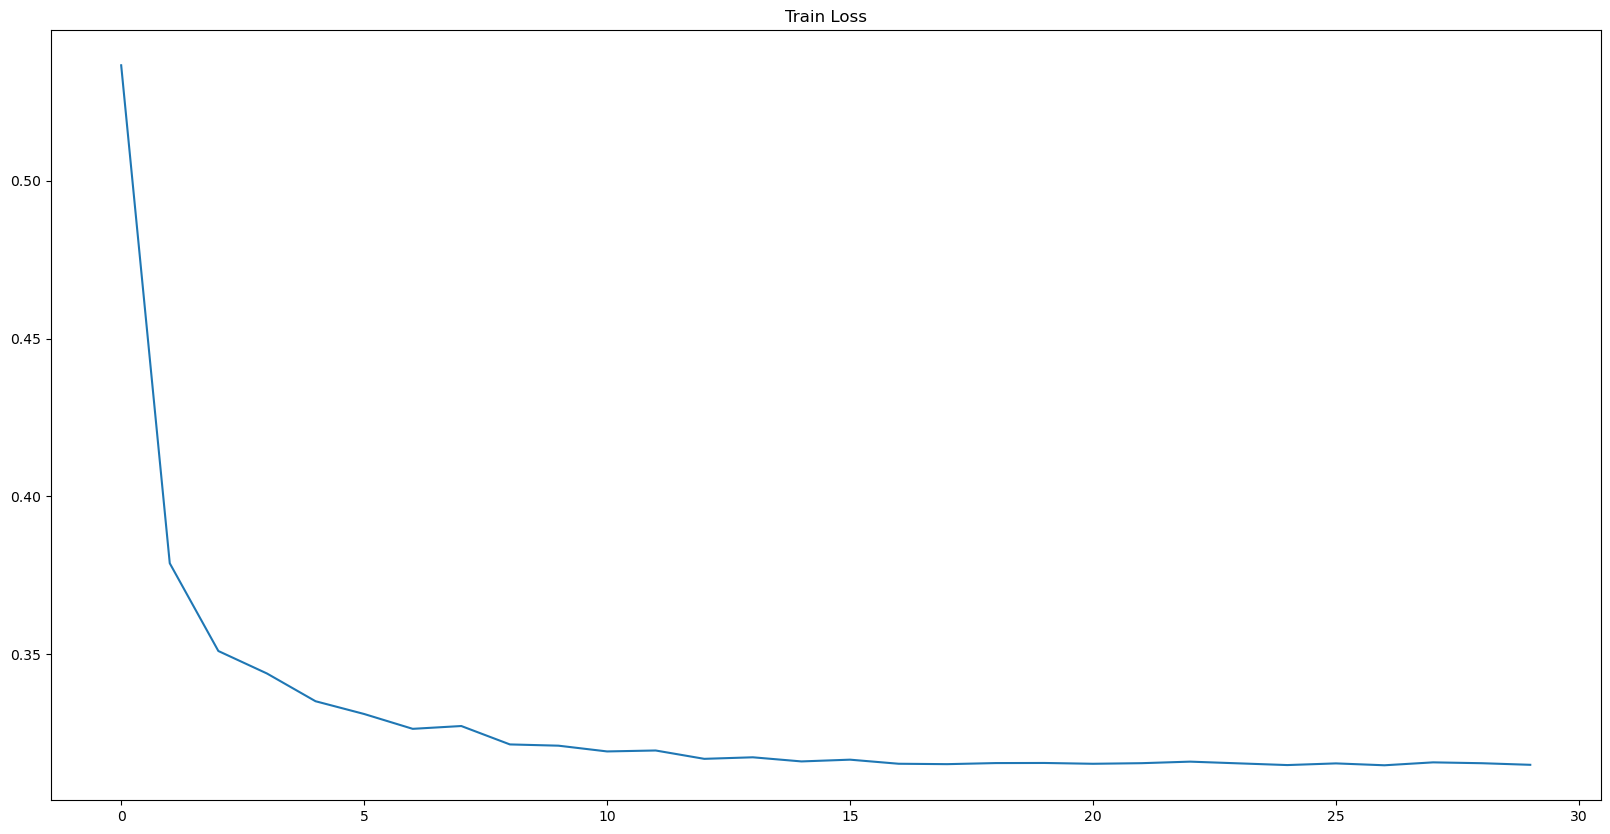

In [20]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

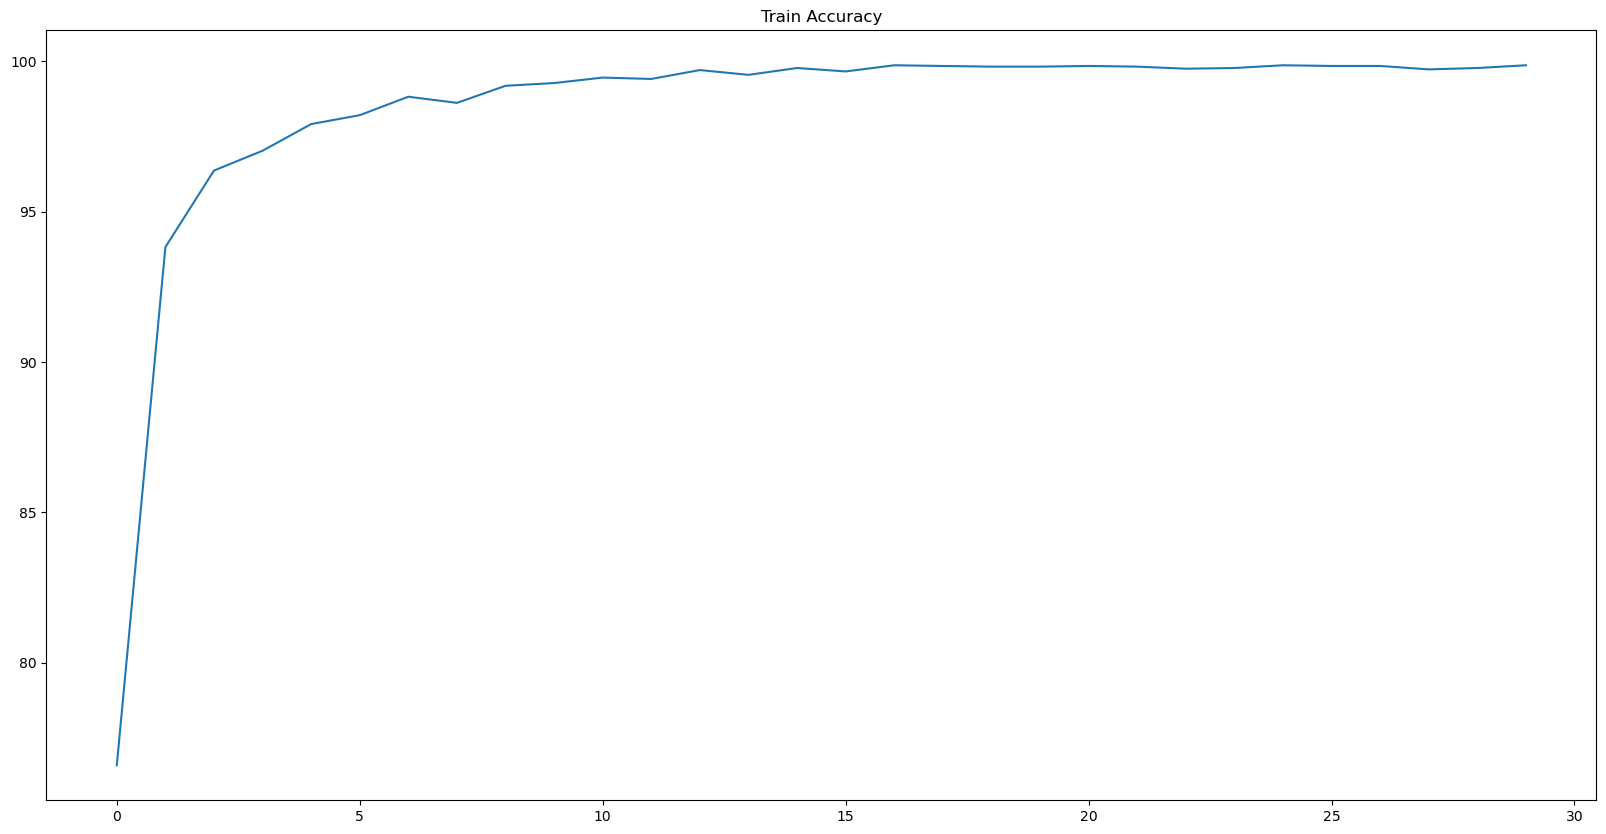

In [21]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')